# AutoBuild Agents function calling 
By: [Krishna Shedbalkar](https://github.com/krishnashed/)

In this notebook, we introduce a way for Agents created using `Autobuild` to do function calling. Developers can specify a function, function name and function description which will thereafter be assigned and executed by the most suitable agent created using AutoBuild.

## Requirement

AutoBuild require `pyautogen[autobuild]`, which can be installed by the following command:

In [ ]:
%pip install pyautogen[autobuild]

## Step 1: Prepare configuration and some useful functions

Prepare a `config_file_or_env` for assistant agent to limit the choice of LLM you want to use in this task. This config can be a path of json file or a name of environment variable. A `default_llm_config` is also required for initialize the specific config of LLMs like seed, temperature, etc...

In [1]:
import autogen
from autogen.agentchat.contrib.agent_builder import AgentBuilder

config_file_or_env = "OAI_CONFIG_LIST"
config_list = autogen.config_list_from_json(config_file_or_env, filter_dict={"model": ["gpt-4-1106-preview", "gpt-4"]})
llm_config = {
    "config_list": config_list,
    "timeout": 120,
}


def start_task(execution_task: str, agent_list: list):
    group_chat = autogen.GroupChat(agents=agent_list, messages=[], max_round=12)
    manager = autogen.GroupChatManager(groupchat=group_chat, llm_config={"config_list": config_list})
    agent_list[0].initiate_chat(manager, message=execution_task)

## Step 2: Create a AgentBuilder

Create a `AgentBuilder` with the specified `config_path_or_env`. AgentBuilder will use `gpt-4` in default to complete the whole process, you can specify the `builder_model` and `agent_model` to other OpenAI model to match your task. You can also specify an open-source LLM supporting by vLLM and FastChat, see blog for more details.

In [2]:
builder = AgentBuilder(
    config_file_or_env=config_file_or_env, builder_model="gpt-4-1106-preview", agent_model="gpt-4-1106-preview"
)

## Step 3: Specify a building task

Specify a building task with a general description. Building task will help build manager (a LLM) decide what agents should be built.

In [3]:
building_task = "Draw two agents chatting with each other with an example dialog using matplotlib."

## Step 4: Define functions

Define functions to be executed by the Agents of AutoBuild, further specify details like `name`, `description` and `function` of all the functions in an array called `list_of_functions` which will be passed to `builder.build()`

In [4]:
from IPython import get_ipython
from typing_extensions import Annotated


def exec_python(cell: Annotated[str, "Valid Python cell to execute."]) -> str:
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


list_of_functions = [
    {
        "name": "exec_python",
        "description": "run cell in ipython and return the execution result.",
        "function": exec_python,
    }
]

## Step 5: build group chat agents

Use `build()` to let build manager (the specified `builder_model`) complete the group chat agents generation. Specify `list_of_functions` to be used by the Agents

In [5]:
agent_list, agent_configs = builder.build(building_task, llm_config, list_of_functions)

==> Generating agents...
['matplotlib_visualization_designer', 'dialogue_content_creator', 'python_matplotlib_developer'] are generated.
==> Generating system message...
Preparing system message for matplotlib_visualization_designer
Preparing system message for dialogue_content_creator
Preparing system message for python_matplotlib_developer
==> Generating description...
Preparing description for matplotlib_visualization_designer
Preparing description for dialogue_content_creator
Preparing description for python_matplotlib_developer
==> Creating agents...
Creating agent matplotlib_visualization_designer with backbone gpt-4-1106-preview...
Creating agent dialogue_content_creator with backbone gpt-4-1106-preview...
Creating agent python_matplotlib_developer with backbone gpt-4-1106-preview...
Adding user console proxy...
Function exec_python is registered to agent python_matplotlib_developer.


Here you can see that Function `exec_python` has been associated with `python_matplotlib_developer` Agent.

## Step 6: execute task

Let agents generated in `build()` to complete the task collaboratively in a group chat.

User_console_and_code_interpreter (to chat_manager):

Draw two agents chatting with each other with an example dialog using matplotlib.

--------------------------------------------------------------------------------

Next speaker: python_matplotlib_developer

python_matplotlib_developer (to chat_manager):

***** Suggested tool call (call_3NA4ghbmsGrw7y8Liua3ibWH): exec_python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\n\n# Draw two agents with a dialog\nfig, ax = plt.subplots(figsize=(6, 4))\n\n# Agent A\nax.text(0.2, 0.6, \"Agent A\", ha='center', va='center', fontsize=12)\ncircle_a = plt.Circle((0.2, 0.5), 0.1, color='blue', fill=True)\nax.add_artist(circle_a)\n\n# Agent B\nax.text(0.8, 0.6, \"Agent B\", ha='center', va='center', fontsize=12)\ncircle_b = plt.Circle((0.8, 0.5), 0.1, color='green', fill=True)\nax.add_artist(circle_b)\n\n# Example dialog\nax.annotate(\"Hello!\", xy=(0.2, 0.5), xytext=(0.4, 0.7), arrowprops=dict(arrowstyle=\"->\"), fontsize=10)\nax.

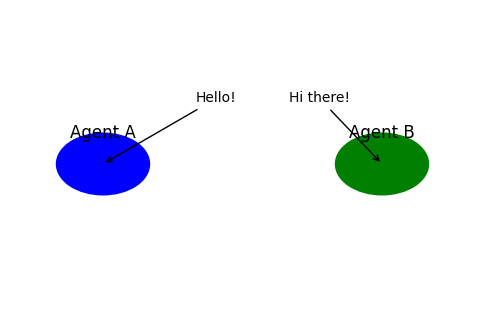

User_console_and_code_interpreter (to chat_manager):

User_console_and_code_interpreter (to chat_manager):

***** Response from calling tool (call_3NA4ghbmsGrw7y8Liua3ibWH) *****
None
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: User_console_and_code_interpreter

User_console_and_code_interpreter (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: matplotlib_visualization_designer

matplotlib_visualization_designer (to chat_manager):

It seems that there might have been an issue as the expected visualization was not displayed. Let me try executing the code snippet again to generate the visual representation of the two agents chatting with an example dialog using matplotlib. Please wait a moment while I process this.

--------------------------------------------------------------------------------

Ne

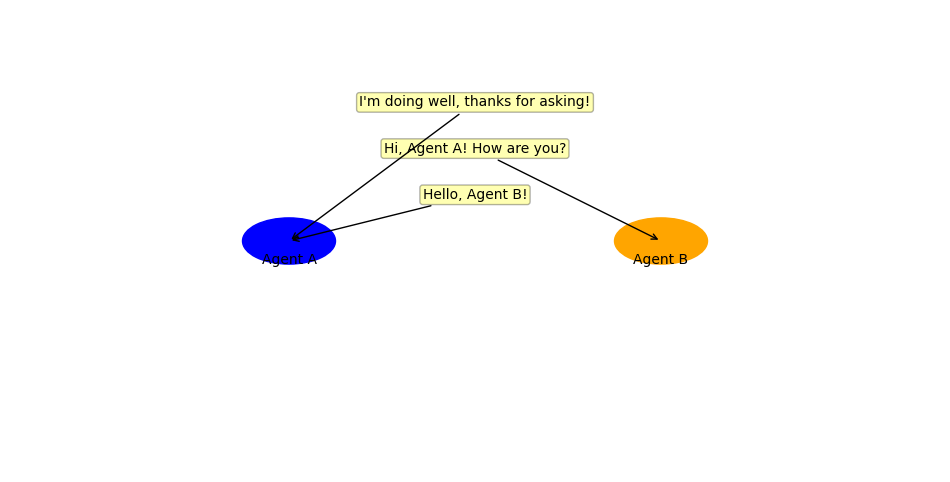

User_console_and_code_interpreter (to chat_manager):

User_console_and_code_interpreter (to chat_manager):

***** Response from calling tool (call_vMx8Xy370lKjaKQlMsiSOKav) *****
None
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: User_console_and_code_interpreter

User_console_and_code_interpreter (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: matplotlib_visualization_designer

matplotlib_visualization_designer (to chat_manager):

It seems that once again we can't view the visualization directly in our chat. However, I have updated the Python code snippet to provide a more detailed dialog between two agents. If you run this code in your local Python environment, it will create a plot featuring two agents engaged in a conversation.

Here's the updated version of the code that you should run in a P

In [6]:
start_task(execution_task=building_task, agent_list=agent_list)

## Step 7 (Optional): clear all agents and prepare for the next task

You can clear all agents generated in this task by the following code if your task is completed or the next task is largely different from the current task. If the agent's backbone is an open-source LLM, this process will also shut down the endpoint server. If necessary, you can use `recycle_endpoint=False` to retain the previous open-source LLMs' endpoint server.

In [7]:
builder.clear_all_agents(recycle_endpoint=True)

All agents have been cleared.


## Save & load configs

You can save all necessary information of the built group chat agents. Here is a case for those agents generated in the above task:

In [8]:
saved_path = builder.save()

Building config saved to ./save_config_673a2266713feeb3b23fbd5a9b1c714f.json
